# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

###### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [63]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.svm import SVC
from xgboost import plot_importance
from xgboost import XGBClassifier

In [2]:
json_users = json.load((open('ultimate_data_challenge.json')))
df_users = json_normalize(json_users)
print(df_users.info())
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


Looks like the data is pretty clean. Let's first determine which users are retained, then let's explore some of the features to see if we can reveal any insights.

In [3]:
df_users['retained'] = [date > '2014-06-01' for date in df_users.last_trip_date]

In [4]:
frac_retained = df_users.retained.value_counts()[1]/df_users.retained.value_counts()[0]
print('Fraction of observed users retained: {:.2f}'.format(frac_retained))

Fraction of observed users retained: 0.58


Let's take a look at retained users by city and phone just out of curiosity.

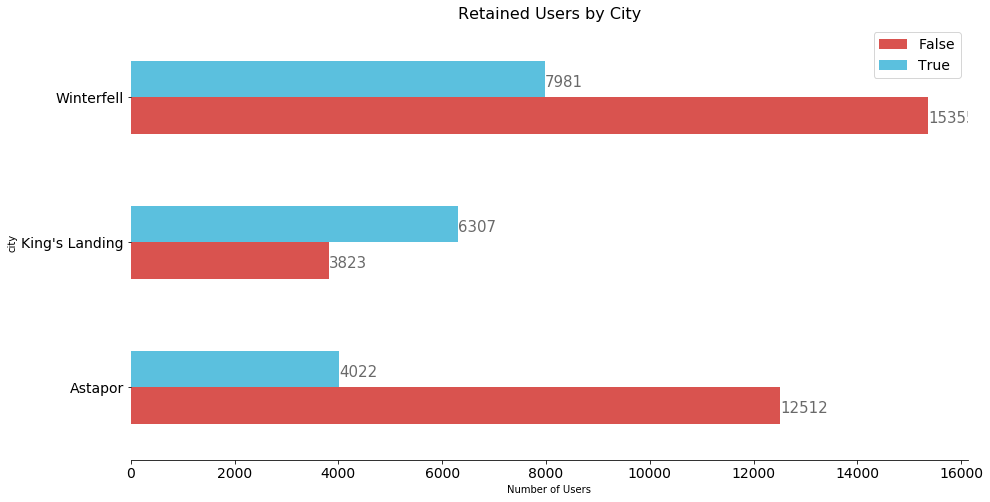

In [5]:
ax = df_users.groupby(['retained'])['city'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by City",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

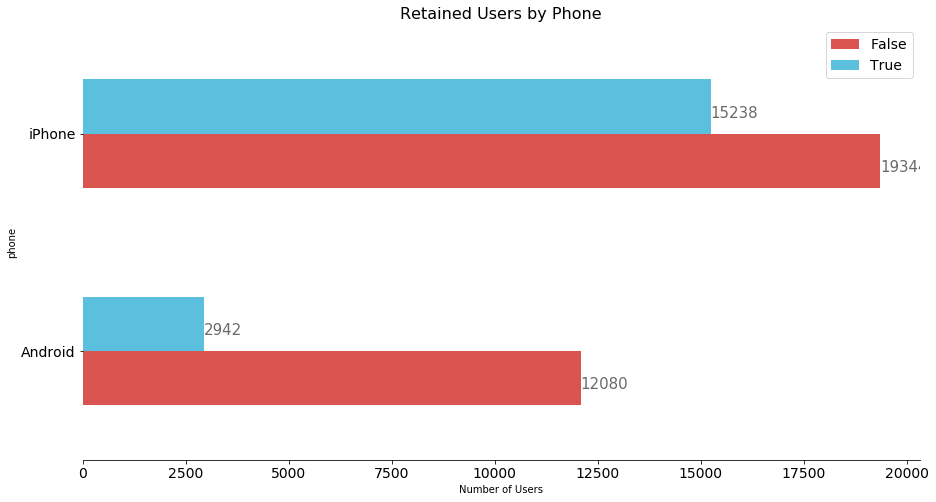

In [6]:
ax = df_users.groupby(['retained'])['phone'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by Phone",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

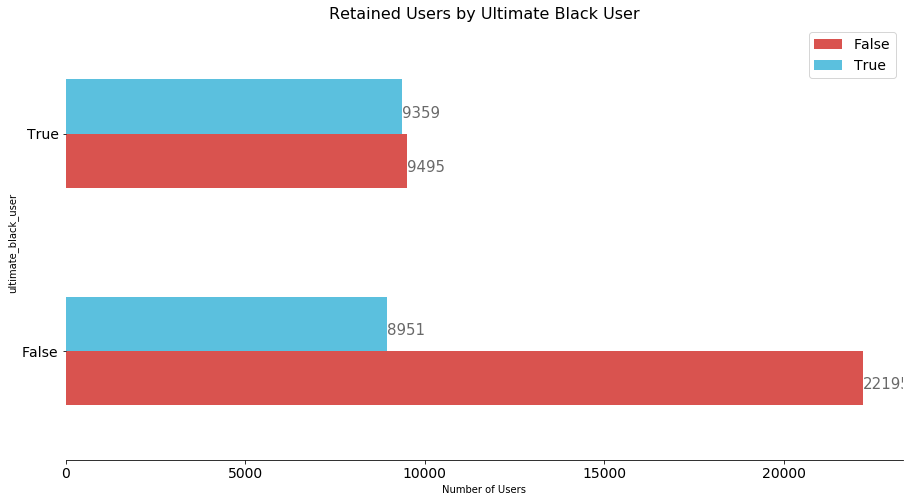

In [7]:
ax = df_users.groupby(['retained'])['ultimate_black_user'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by Ultimate Black User",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

Looks like users in King's Landing are more likely to be retained than any other city, and iPhone users are more likely to be retained than Android users. In addition, looks like Ultimate Black Users are more likely to be retained than Ultimate Black non-users.

###### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
    
First let's determine all observed users who have been active for at least 5 months and 1 day to determine if they are still active in their 6th month. For our purposes we will consider each month to have the monthly average of 30.4 days. Therefore, any user that is still active after $30.4 * 5 = 152$ days of creating their account will be considered active in their 6th month.

In [10]:
sixth_month_active = [(pd.to_datetime(df_users.last_trip_date.iloc[i]) \
                       - pd.to_datetime(df_users.signup_date.iloc[i])).days > 152 for i in range(len(df_users))]

In [11]:
df_users['sixth_month_active'] = sixth_month_active
df_users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,sixth_month_active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True,False
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False,False


In [62]:
df_users['sixth_month_active'].value_counts()

False    38806
True     11194
Name: sixth_month_active, dtype: int64

In [12]:
df_users_train, df_users_test = train_test_split(df_users, test_size=0.2, random_state=4)

Now let's one hot encode the categorical columns and then use Sklearn's ExtraTreesClassifier to calculate feature importances then we'll move on to feature selection and model building.

In [13]:
# binarizing 'city' and 'phone' columns
df_users_train = pd.concat([df_users_train, pd.get_dummies(df_users_train['city']), 
                            pd.get_dummies(df_users_train['phone'])], axis=1)

# converting 'ultimate_black_user' and 'sixth_month_active' columns from bool to int
df_users_train['ultimate_black_user'] = df_users_train['ultimate_black_user'].astype('uint8')
df_users_train['sixth_month_active'] = df_users_train['sixth_month_active'].astype('uint8')

df_users_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,sixth_month_active,Astapor,King's Landing,Winterfell,Android,iPhone
16880,7.59,5.0,5.0,1.00,King's Landing,2014-02-02,iPhone,2014-01-30,0.0,2,0,50.0,False,0,0,1,0,0,1
18337,8.09,5.0,4.8,1.02,Astapor,2014-06-29,iPhone,2014-01-10,8.3,2,0,75.0,True,1,1,0,0,0,1
11170,2.17,3.0,4.0,1.00,Astapor,2014-03-02,iPhone,2014-01-13,0.0,0,0,0.0,False,0,1,0,0,0,1
17714,1.99,4.7,5.0,1.00,Winterfell,2014-03-16,iPhone,2014-01-29,0.0,2,0,66.7,False,0,0,0,1,0,1
28539,10.35,2.0,NaN,1.00,Winterfell,2014-02-09,iPhone,2014-01-05,0.0,0,0,0.0,False,0,0,0,1,0,1


Feature ranking:
1. avg_dist (0.290748)
2. weekday_pct (0.154598)
3. trips_in_first_30_days (0.107209)
4. avg_rating_by_driver (0.102734)
5. avg_rating_of_driver (0.098568)
6. surge_pct (0.088158)
7. avg_surge (0.074776)
8. ultimate_black_user (0.022475)
9. King's Landing (0.020295)
10. Android (0.013789)
11. iPhone (0.013740)
12. Astapor (0.008520)
13. Winterfell (0.004387)


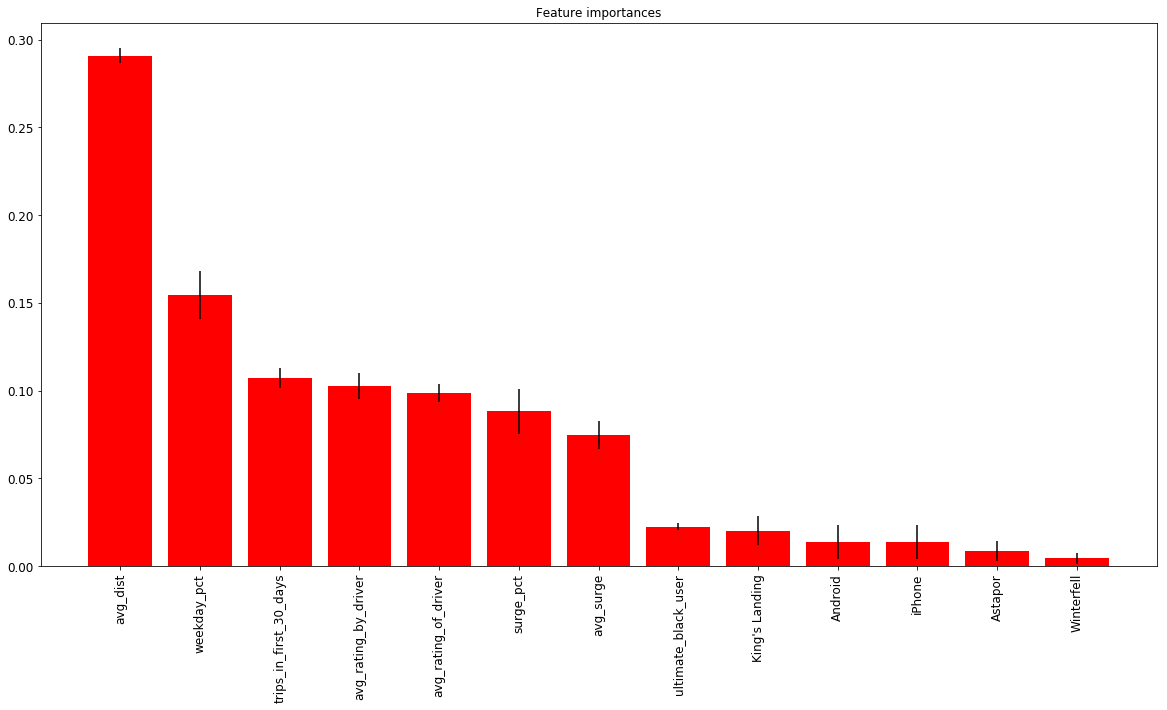

In [141]:
# imputing missing values with the mean using sklearn's SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# selecting all features to compute importance
features = df_users_train.iloc[:, [0,1,2,3,8,9,10,11,14,15,16,17,18]].columns
X_train = df_users_train[features]

# setting target variable
y_train = df_users_train.loc[:,'sixth_month_active']


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(imp_mode.fit_transform(X_train), y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = [X_train.columns[index] for index in indices] #reordering features by importance
sorted_importances = [importances[index] for index in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), features)
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=12)
plt.show()

Now that we know the relative importances of the features, let's build our model see how it performs first selecting all features, and then removing some of the less important features. I generally like XGBoost for binary classification problems like this because it performs quite fast is in comparison to other tree ensemble methods like random forest, and is also good at reducing variance as well as bias. However, we'll also consider Logistic Regression for comparison. We'll perform 5-fold cross validation as well to prevent over fitting, and since this dataset is imbalanced we'll use balanced accuracy, the average of recall obtained on each class to evaluate and compare the models. 

In [139]:
# selecting features to train models
X_train = df_users_train[features]

# setting target variable
y_train = df_users_train.loc[:,'sixth_month_active']


# repeating pre-processing for the test data

# one-hot encoding of 'fittype' feature
df_users_test = pd.concat([df_users_test, pd.get_dummies(df_users_test['city']), 
                           pd.get_dummies(df_users_test['phone'])], axis=1)

# converting 'ultimate_black_user' and 'sixth_month_active' columns from bool to int
df_users_test['ultimate_black_user'] = df_users_test['ultimate_black_user'].astype('uint8')
df_users_test['sixth_month_active'] = df_users_test['sixth_month_active'].astype('uint8')


X_test = df_users_test[features]
y_test = df_users_test.loc[:,'sixth_month_active']

In [18]:
def return_time(seconds):
    '''converts seconds to hours, minutes, and seconds'''
    d = str(dt.timedelta(seconds=round(seconds)))
    hours = d[:len(d)-6]
    minutes = d[-5:-3]
    seconds_left = d[-2:]
    periods = [('hours', hours), ('minutes', minutes), ('seconds', seconds_left)]
    time_string = ' '.join('{} {}'.format(value, name)
                        for name, value in periods
                        if int(value) != 0)
    return time_string

In [23]:
# create LogisticRegression model and pipeline
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=7)
lr_steps = [('imputation', imp_mode), ('scaler', StandardScaler()), ('LR', logreg)]
lr_pipeline = Pipeline(lr_steps)

# paramater space to tune
c_space = np.logspace(-5,8,15)
lr_param_grid = {'LR__C': c_space}

In [42]:
start = time.time()
# apply 5 fold cross validation with RandomizedSearchCV to find best hyper-paramters and fit model
logreg_cv = RandomizedSearchCV(lr_pipeline, lr_param_grid, scoring='balanced_accuracy', cv=5, random_state=10)
logreg_cv.fit(X_train, y_train)

# print results
print("5 fold cross validation results")
print("---------------------------------------------------------------------")
print("Logistic Regression took {} to fit.".format(return_time(time.time() - start)))
print("Mean balanced accuracy: {:.3f}".format(np.mean(logreg_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv.cv_results_['std_test_score'])))

5 fold cross validation results
---------------------------------------------------------------------
Logistic Regression took 23 seconds to fit.
Mean average precision: 0.552
Standard deviation: 0.002


Let's see how this compares with XGBoost.

In [72]:
xgb = XGBClassifier(subsample=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=7)
xgb_steps = [('imputation', imp_mode), ('scaler', StandardScaler()), ('XGB', xgb)]
xgb_pipeline = Pipeline(xgb_steps)

# paramater space to tune
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [3, 4, 5, 6, 8, 10, 12, 15]
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
min_child_weight = [1, 3, 5, 7]
gamma = [0.0, 0.1, 0.2 , 0.3, 0.4]
colsample_bytree = [0.3, 0.4, 0.5 , 0.7]

xgb_param_grid = {'XGB__max_depth': max_depth, 
                  'XGB__learning_rate': learning_rate, 
                  'XGB__n_estimators': n_estimators, 
                  'XGB__gamma': gamma, 
                  'XGB__min_child_weight': min_child_weight, 
                  'XGB__colsample_bytree': colsample_bytree,
}

In [91]:
start = time.time()
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='balanced_accuracy', cv=5, random_state=10)
xgb_cv.fit(X_train, y_train)

# print results
print("5 fold cross validation results")
print("---------------------------------------------------------------------")
print("XGBoost took {} to fit.".format(return_time(time.time() - start)))
print("Mean balanced accuracy: {:.3f}".format(np.mean(xgb_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv.cv_results_['std_test_score'])))

5 fold cross validation results
---------------------------------------------------------------------
XGBoost took 17 minutes 20 seconds to fit.
Mean balanced accuracy: 0.650
Standard deviation: 0.004


Look's like XGBoost significantly outperforms Logistic Regression here so let's move forward using just XGBoost and see how it performs on smaller subsets of more important features. We'll remove the least important features one by one to see if the balanced accuracy improves and use the model with the highest mean 5 fold CV balanced accuracy to evaluate the model on the test data.

In [73]:
start = time.time()
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv1 = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='balanced_accuracy', cv=5, random_state=10)
xgb_cv1.fit(X_train[features[:12]], y_train)

# print results
print("5 fold cross validation results")
print("---------------------------------------------------------------------")
print("XGBoost took {} to fit.".format(return_time(time.time() - start)))
print("Mean balanced accuracy: {:.3f}".format(np.mean(xgb_cv1.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv1.cv_results_['std_test_score'])))

5 fold cross validation results
---------------------------------------------------------------------
XGBoost took 14 minutes 19 seconds to fit.
Mean balanced accuracy: 0.651
Standard deviation: 0.004


In [45]:
start = time.time()
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv2 = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='balanced_accuracy', cv=5, random_state=10)
xgb_cv2.fit(X_train[features[:11]], y_train)

# print results
print("5 fold cross validation results")
print("---------------------------------------------------------------------")
print("XGBoost took {} to fit.".format(return_time(time.time() - start)))
print("Mean balanced accuracy: {:.3f}".format(np.mean(xgb_cv2.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(xgb_cv2.cv_results_['std_test_score'])))

5 fold cross validation results
---------------------------------------------------------------------
XGBoost took 19 minutes 10 seconds to fit.
Mean balanced accuracy: 0.646
Standard deviation: 0.004


Looks like the last feature 'Winterfell', does not provide any useful information in predicting whether or not a user will be active in their sixth month, but all the other features (even the lesser important ones) do seem to help at least a little. Let's see how our final model (with the feature 'Winterfell' omitted) performs on the test data.

Test set balanced accuracy: 0.659
Confusion matrix, without normalization
[[7226  540]
 [1367  867]]


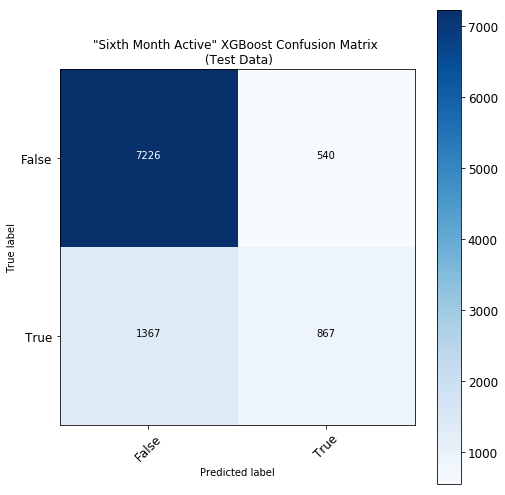

In [61]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred = xgb_cv1.predict(X_test[features[:12]])
classes = ['False', 'True']

print('Test set balanced accuracy: {:.3f}'.format(balanced_accuracy_score(y_test, y_pred)))
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=classes,
                      normalize= False,  title='"Sixth Month Active" XGBoost Confusion Matrix \n (Test Data)')    

###### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

Looks like the test accuracy at 66% is slightly better than the cross validated score. The confusion matrix above shows that the model is a bit better at predicting users who will not be active in their sixth month, so it might be better to focus on those users and provide incentives to encourage them to use the service more.

The feature importances classified by the ExtraTreesClassifier suggest that the top 3 most important features in predicting users who are active on their sixth month after sign up are:

    - avg_dist: Average distance in miles per trip taken in the first 30 days after signup
    - weekday_pct: the percent of the user’s trips occurring during a weekday
    - trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

Let's take a look at these features a little closer by plotting histograms of both sixth month active users and non sixth month active users.

In [168]:
def plot_hists(df, target_var, column, ylabel, c_bins=50, f_bins= 50, logy=False, f_scale='linear'):
    '''Plots a histogram for each disposition (confirmed (c)/false positive (f)) of a given dataframe and column.'''
    fig = plt.figure() # create figure
    # plt.subplots
    axc = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
    axf = fig.add_subplot(1, 2, 2)

    df[df[target_var] == df[target_var].unique()[0]][column].plot(kind='hist', logy=logy, bins=c_bins, ax=axc, 
                                                         figsize=(20,6), ec='black')
    
    axc.set_title(target_var + ' = ' + 'False')
    axc.set_xlabel(column)
    axc.set_ylabel(ylabel)
    

    df[df[target_var] == df[target_var].unique()[1]][column].plot(kind='hist', logy=logy, bins=f_bins, ax=axf, 
                                                              figsize=(20,6), ec='black')
    
    axf.set_xscale(f_scale)
    axf.set_title(target_var + ' = ' + 'True')
    axf.set_xlabel(column)
    axf.set_ylabel(ylabel)

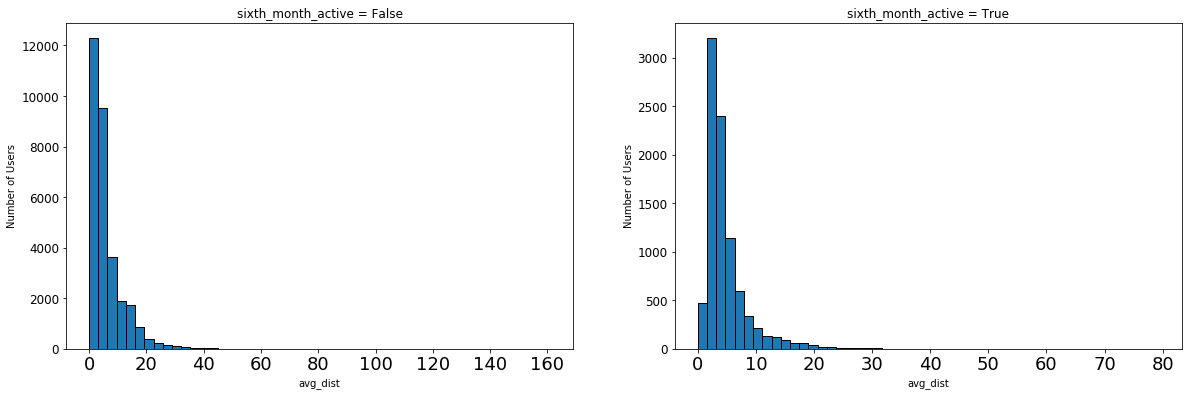

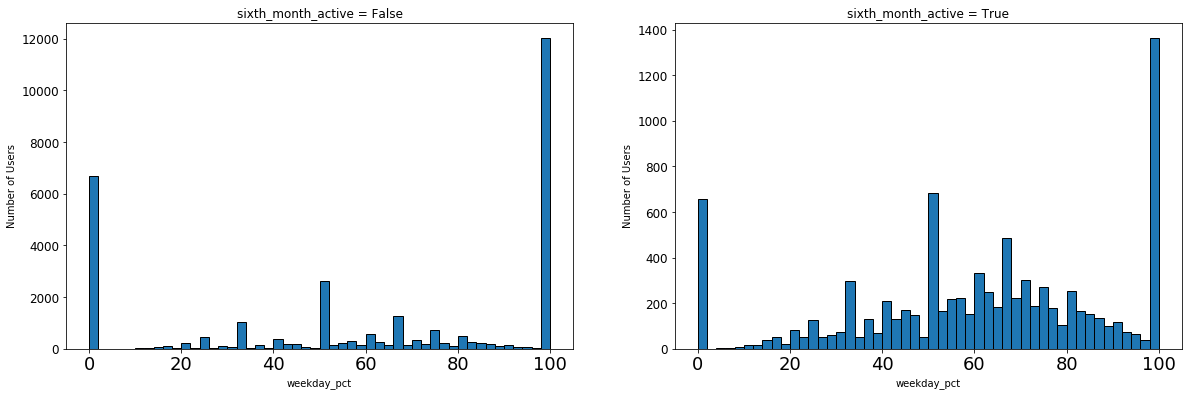

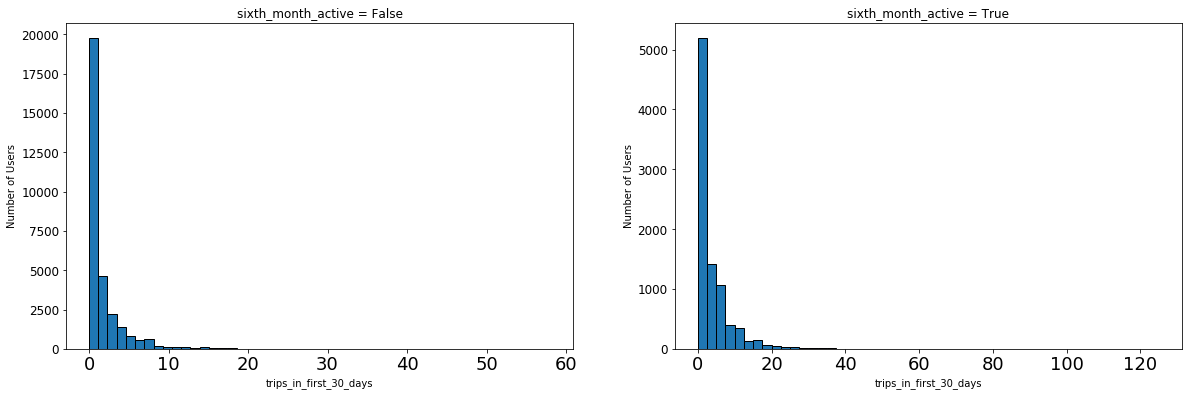

In [169]:
for feature in features[:3]:
    plot_hists(df_users_train, 'sixth_month_active', feature, ylabel= 'Number of Users')

In [175]:
mean_dista = df_users_train[df_users_train['sixth_month_active'] == False]['avg_dist'].mean()
print('Mean avg_dist of non sixth month active users: {:.2f}'.format(mean_dista))
      
mean_distb = df_users_train[df_users_train['sixth_month_active'] == True]['avg_dist'].mean()
print('Mean avg_dist of sixth month active users: {:.2f}'.format(mean_distb))

Mean avg_dist of non sixth month active users: 6.07
Mean avg_dist of sixth month active users: 4.82


In [176]:
tripsa = df_users_train[df_users_train['sixth_month_active'] == False]['trips_in_first_30_days'].mean()
print('Mean trips_in_first_30_days of non sixth month active users: {:.2f}'.format(tripsa))
      
tripsb = df_users_train[df_users_train['sixth_month_active'] == True]['trips_in_first_30_days'].mean()
print('Mean trips_in_first_30_days of sixth month active users: {:.2f}'.format(tripsb))

Mean trips_in_first_30_days of non sixth month active users: 1.87
Mean trips_in_first_30_days of sixth month active users: 3.69


In [177]:
weekdaya = df_users_train[df_users_train['sixth_month_active'] == False]['weekday_pct'].mean()
print('Mean weekday_pct of non sixth month active users: {:.2f}'.format(weekdaya))
      
weekdayb = df_users_train[df_users_train['sixth_month_active'] == True]['weekday_pct'].mean()
print('Mean weekday_pct of sixth month active users: {:.2f}'.format(weekdayb))

Mean weekday_pct of non sixth month active users: 61.07
Mean weekday_pct of sixth month active users: 60.92


Looks like the average distance in miles per trip taken in the first 30 days after signing up is a little higher for non sixth month active users, while the number of trips the non sixth month active users took in the first 30 days after signing up is lower. Therefore one way to maybe leverage this insight is to encourage riders to take shorter trips in their first 30 days by offering discounted rides if they are below a certain distance. In addition, encouraging riders in their first 30 days of signing up to take more trips by offering discounts may also make them become a long term user. Regardless it seems like the first 30 days experience for riders is important for whether or not they stay active after six months so it's important to make sure the first 30 days experience enjoyable for them if they are to stick around long term. Looks like the mean weekday_pct of both types of users is pretty close, as well as the distribution, so this might not be as useful of a feature to pull intuitive insights from.